In [1]:
import pickle
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
from wordcloud import WordCloud
import pickle
import matplotlib.pyplot as plt
import math
import scipy
from networkx.algorithms import bipartite
import numpy as np
import random

Load Data

In [2]:

with open('full_data.pkl', 'rb') as f:
    df = pickle.load(f)
print(df.head())
print(len(df))

               time_posted               blog_name       post_id post_type  \
0  2018-03-13 01:24:50 GMT  hometown-helen-of-troy  171814404387     photo   
1  2018-03-13 01:24:25 GMT  hometown-helen-of-troy  171814392952     photo   
2  2018-02-27 05:49:52 GMT        prettyandpurple0  171335923889      text   
3  2018-02-04 13:08:35 GMT       dykemesticgoddess  170492840461      text   
4  2018-02-04 13:04:47 GMT       dykemesticgoddess  170492764641      text   

  image_urls                                               tags  \
0         []         [baking, homemaking, traditional, tradfem]   
1         []  [marilyn monroe, tradfem, traditional, feminin...   
2         []  [tradfem, traditional life, traditional, house...   
3         []  [domestblr, tradfem, housewife, housekeeping, ...   
4         []                    [domestblr, housewife, tradfem]   

                                            post_url  
0  https://hometown-helen-of-troy.tumblr.com/post...  
1  https://hometow

In [3]:
#getting tradwife "score" 
def get_tradwife_score(tags):
    return tags.count('tradwife')+tags.count('tradfem')+tags.count('tradblr')

df['tradwife_score']=df.apply(lambda row: get_tradwife_score(row['tags']), axis=1)
tradwifescores = df.groupby(by=["blog_name"])['tradwife_score'].sum()


Function to make bipartite graphs

In [4]:
def make_bipartite(df):
    B = nx.Graph()
    #getting tradwife scores
    df['tradwife_score']=df.apply(lambda row: get_tradwife_score(row['tags']), axis=1)
    tradwifescores = df.groupby(by=["blog_name"])['tradwife_score'].sum()

    for index, row in df.iterrows():
        if row['blog_name'] not in B.nodes():
            B.add_node(row['blog_name'], type = 'user', tradwifescore=tradwifescores[row['blog_name']])
        for tag in row['tags']:
            if '#'+tag not in B.nodes():
                B.add_node('#'+tag, type = 'tag')
            B.add_edge('#'+tag, row['blog_name'])
    print("Is bipartite? "+str(bipartite.is_bipartite(B)))
    print("Num nodes: "+str(len(B.nodes())))
    print("Num edges: "+str(len(B.edges())))
    return B

Degree distribution and Betweeness Centrality

In [5]:

def plot_degree(G, number_of_bins=50, log_binning=True, base=2, label="Degree", title="Degree Distribution"):
    """
    Given a graph, return the y values (probability) and the
    x values (support) of a degree distribution that you're going to plot and
    plot the distribution.
    
    Parameters
    ----------
    degree (nx graph):
        network x graph (undirected)

    number_of_bins (int):
        length of output vectors
    
    log_binning (bool)
        if you are plotting on a log-log axis, then this is useful
    
    base (int):
        log base, defaults to 2
        
    Returns
    -------
    x, y (np.ndarray):
        the support and probability values of the degree distribution
    
    """
    degree = np.array(list(dict(G.degree()).values()))

    # We need to define the support of our distribution
    lower_bound = min(degree)
    upper_bound = max(degree)
    
    # And the bins
    if log_binning:
        log = np.log2 if base == 2 else np.log10
        lower_bound = log(lower_bound) if lower_bound >= 1 else 0.0
        upper_bound = log(upper_bound)
        bins = np.logspace(lower_bound,upper_bound,number_of_bins, base = base)
    else:
        bins = np.linspace(lower_bound,upper_bound,number_of_bins)
    
    # Then we can compute the histogram using numpy
    y, __ = np.histogram(degree, 
                         bins=bins,
                         density=True)
    # Now, we need to compute for each y the value of x
    x = bins[1:] - np.diff(bins)/2.0

    fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=150)

    ax.loglog(x, y,'o', label=label, alpha=0.8)

    ax.set_xlabel(r"$k$", fontsize=16)
    ax.set_ylabel(r"$P(k)$", fontsize=16)
    ax.set_title(title)

    ax.legend(fontsize=14)
    plt.show()

Analyzing bridge tags

Modeling

In [7]:
#when does tradwife content begin to be posted? looks like we should look at 2019-2022 posts
df['time_posted'] = pd.to_datetime(df.time_posted)
timeseriesdf = df.groupby(df.time_posted.dt.to_period('M')).sum('tradwife_score').reset_index()
timeseriesdf.plot('time_posted', 'tradwife_score', legend=None, figsize=(6,4))
plt.xlabel("Time")
plt.ylabel("Tradwife Tags Posted")
plt.title("Tradwife Content over Time on Tumblr")

c:\Users\melka\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


KeyError: 'tradwife_score'

In [6]:
#constructing this bipartite network 2019-2022
smalldf = df[(df['time_posted'] > '2019-01-01 00:00:00') & (df['time_posted'] < '2022-11-11 00:00:00')]
G = make_bipartite(smalldf)

C:\Users\melka\AppData\Local\Temp\ipykernel_18092\2953207649.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tradwife_score']=df.apply(lambda row: get_tradwife_score(row['tags']), axis=1)


Is bipartite? True
Num nodes: 174220
Num edges: 660006


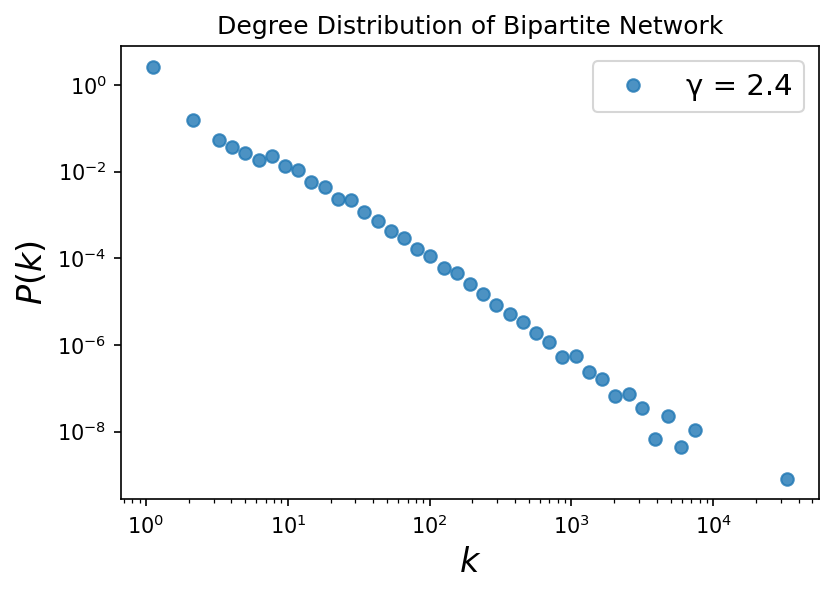

In [84]:
#degree distribution
plot_degree(G, label='γ = '+str(round(fit.alpha, 2)), title="Degree Distribution of Bipartite Network")

In [64]:
#getting power law fit
import powerlaw
fit= powerlaw.Fit(sorted([d for n, d in G.degree()], reverse=True))
print('gamma = '+str(fit.alpha))

NameError: name 'G' is not defined

In [7]:
#construct a tree of tradwife nodes, tags, and then cottagecore blogs attached to those tags
def build_bridge(G):
    tradwife_users = [x for x,y in G.nodes(data=True) if 'tradwifescore' in y and y['tradwifescore']>=1]
    T = nx.Graph()
    T.add_nodes_from(tradwife_users, type='tradwife', mode = 1)
    for tradwife_blog in tradwife_users:
        for tag in G.neighbors(tradwife_blog): #for each tag posted by tradwife user add a node
            if tag not in T.nodes():
                T.add_node(tag, type='tag', mode = 2)
                T.add_edge(tradwife_blog, tag)
            for cottagecore_blog in G.neighbors(tag): #add edges to only cottagecore nodes connected to by these tags
                if cottagecore_blog not in T.nodes():
                    T.add_node(cottagecore_blog, type = 'cottagecore', mode = 3)
                    T.add_edge(cottagecore_blog, tag)
    T.remove_nodes_from(list(nx.isolates(T)))
    return T


In [8]:
T = build_bridge(G)

In [225]:
#saving for visualization
nx.write_graphml(T, "bridge.graphml")

In [12]:
print(len(T.nodes()))
print(len(T.edges()))
print(len([x for x,y in T.nodes(data=True) if y['type']=='cottagecore']))
print(len([x for x,y in T.nodes(data=True) if y['type']=='tradwife']))
print(len([x for x,y in T.nodes(data=True) if y['type']=='tag']))


45129
44505
36767
624
7738


In [13]:
print(len([x for x,y in T.nodes(data=True) if y['type']=='cottagecore'])) #original number of cottagecore blogs connected to tradwife content

36767


In [22]:
tag_nodes = [x for x,y in T.nodes(data=True) if y['type']=='tag']
tag_score = {"tag":tag_nodes, "score":[]}

i = 0

for tag in tag_nodes:
    R = T.copy()
    R.remove_node(tag)
    R.remove_nodes_from(list(nx.isolates(R))) #removing singletons created by removing tag
    tag_score['score'].append(len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']))
    if i%100==0:
        print(i)
    i = i + 1

0


KeyboardInterrupt: 

In [41]:
print("saving to pickle file...")
df = pd.DataFrame.from_dict(tag_score)
df.to_pickle("tag_score.pkl", compression='infer', protocol=5, storage_options=None)

saving to pickle file...


In [9]:
with open('tag_score.pkl', 'rb') as f:
    tag_score_df = pickle.load(f)
print(tag_score_df.head())

                 tag  score
0         #ramblings  36722
1           #tradfem  36767
2              #sahm  36763
3  #stay at home mom  36763
4  #stay at home mum  36767


In [10]:
#converting to percentages and sorting 
tag_score_df["score"]=(36767-tag_score_df["score"])/36767

In [11]:
print(tag_score_df.sort_values("score", ascending=False).head(20))

               tag     score
399   #cottagecore  0.658471
9          #nature  0.176544
10        #flowers  0.064922
7          #baking  0.038350
23        #animals  0.008758
162           #tea  0.007289
6         #cookies  0.006881
8         #cooking  0.006228
2430  #Cottagecore  0.004950
64          #bread  0.003998
11         #floral  0.003862
62       #knitting  0.002992
48       #homemade  0.002285
389     #homestead  0.001469
156          #cake  0.001224
0       #ramblings  0.001224
39         #please  0.001006
163        #teapot  0.000979
271           #jam  0.000734
20     #homemaking  0.000571


In [12]:
#plotting removal of tag nodes in random order, using T
R = T.copy()
x = [0, ]
y_random = [len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']), ]

i = 1

tags = list(tag_score_df["tag"])
random.shuffle(tags)

for tag in tags:
    R.remove_node(tag)
    R.remove_nodes_from(list(nx.isolates(R))) #removing singletons created by removing tag
    x.append(i)
    y_random.append(len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']))
    i = i + 1
    if i%100==0:
        print(i)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700


In [13]:
#plotting removal of tag nodes in order of tag score, using T
R = T.copy()
x = [0, ]
y = [len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']), ]

i = 1

for tag in tag_score_df.sort_values("score", ascending=False)["tag"]:
    R.remove_node(tag)
    R.remove_nodes_from(list(nx.isolates(R))) #removing singletons created by removing tag
    x.append(i)
    y.append(len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']))
    i = i + 1
    if i%100==0:
        print(i)



100
200
300
400
500
600
700
800
900
1000
1100


KeyboardInterrupt: 

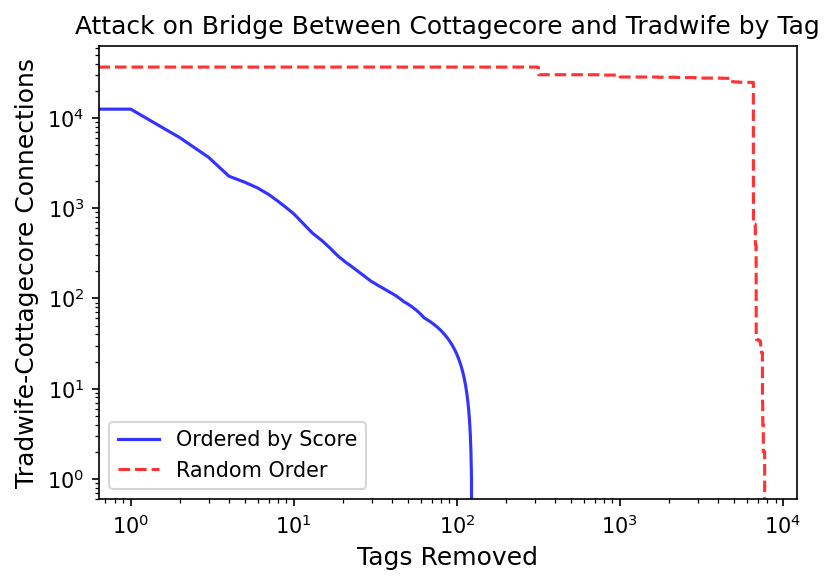

In [19]:
fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=150)

ax.loglog(x, y,'-', alpha=0.8, color = 'b', label="Ordered by Score")
ax.loglog(x, y_random, '--', alpha=0.8, color = 'r', label="Random Order")

ax.set_xlabel("Tags Removed", fontsize=12)
ax.set_ylabel("Tradwife-Cottagecore Connections", fontsize=12)
ax.legend()
ax.set_title("Attack on Bridge Between Cottagecore and Tradwife by Tag")

plt.show()

In [ ]:
#trying to remove tags that have to do with tradwives from manual annotation

In [32]:
#saving to excel to examine tags
tag_score_df.to_excel("tags.xlsx")
tradwife_tags = ["#traditional", "#trad", "#traditional femininity", "#sahm", "#stay at home mom", "#modesty", "#Tradwife", "#traditional gender roles", "#Tradfem", "#feminism", "#feminine"]

In [34]:
#plotting removal of tradwife tag nodes in order of tag score, using T
R = T.copy()
x_trad = [0, ]
y_trad = [len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']), ]

i = 1

for tag in tradwife_tags:
    R.remove_node(tag)
    R.remove_nodes_from(list(nx.isolates(R))) #removing singletons created by removing tag
    x_trad.append(i)
    y_trad.append(len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']))
    i = i + 1
    if i%100==0:
        print(i)


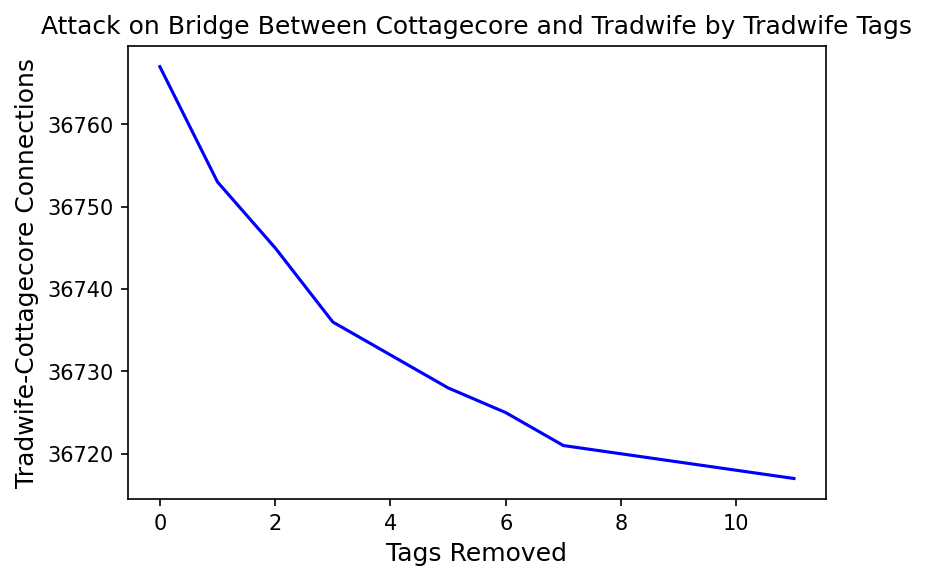

In [42]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=150)

ax.plot(x_trad, y_trad, 'b-')

ax.set_xlabel("Tags Removed", fontsize=12)
ax.set_ylabel("Tradwife-Cottagecore Connections", fontsize=12)
ax.set_title("Attack on Bridge Between Cottagecore and Tradwife by Tradwife Tags")

plt.show()

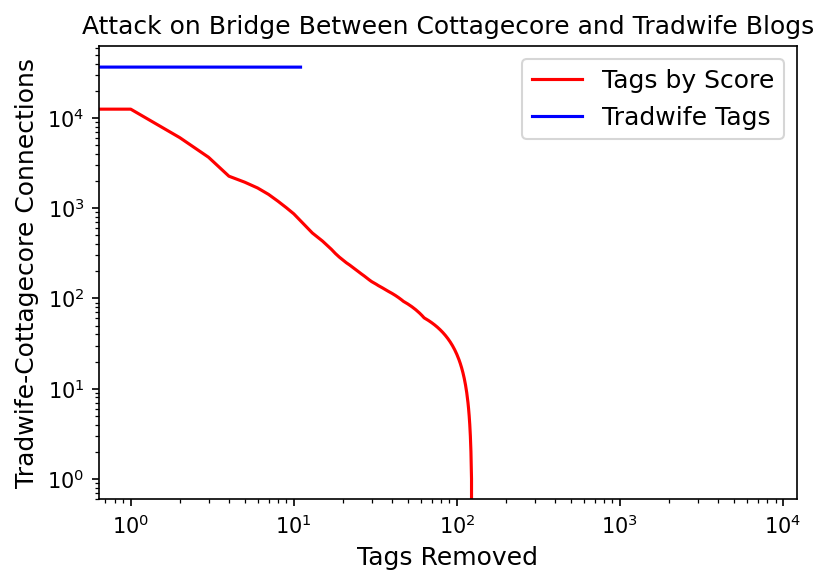

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=150)

ax.loglog(x, y,'r-', label = "Tags by Score")
ax.loglog(x_trad, y_trad, 'b-', label="Tradwife Tags")

ax.set_xlabel("Tags Removed", fontsize=12)
ax.set_ylabel("Tradwife-Cottagecore Connections", fontsize=12)
ax.legend(fontsize=12)
ax.set_title("Attack on Bridge Between Cottagecore and Tradwife Blogs")

plt.show()

In [24]:
#removing tradwife users, first getting degree and tradwife score in dict
import pandas as pd
tradwife_blogs = [x for x,y in T.nodes(data=True) if y['type']=='tradwife']
tradwife_dict = {'blog':tradwife_blogs, 'degree':[], 'tradwifescore':[]}
for blog in tradwife_blogs:
    tradwife_dict['degree'].append(T.degree(blog))
    tradwife_dict['tradwifescore'].append(G.nodes[blog]["tradwifescore"])
tradwife_df = pd.DataFrame.from_dict(tradwife_dict)


In [59]:
#removing tradwife blogs in order of degree
R = T.copy()
x_deg = [0, ]
y_deg = [len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']), ]

i = 1

for blog in tradwife_df.sort_values("degree", ascending=False)["blog"]:
    #get all tags potentially affected by this blog removal
    try: 
        tags = R.neighbors(blog)
        R.remove_node(blog)
        #get all tags that now do not connect to any tradfem users and remove them
        j = 0
        for tag in tags:
            neighbordata = [(k, dict(R.nodes(data=True))[k]) for k in R.neighbors(tag)]
            if len([x for x,y in neighbordata if y['type']=='tradwife'])==0: #if tag no longer has any tradwife neighbors
                R.remove_node(tag)
        R.remove_nodes_from(list(nx.isolates(R))) #removing singletons created by removing tag
        x_deg.append(i)
        y_deg.append(len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']))
    except nx.NetworkXError: #blog has already been removed
        x_deg.append(i)
        y_deg.append(len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']))
    i = i + 1
    print("step"+str(i))
    # if i%100==0:
    #     print(i)

#removing blogs in order of score
R = T.copy()
x_tradwife = [0, ]
y_tradwife = [len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']), ]

i = 1

for blog in tradwife_df.sort_values("tradwifescore", ascending=False)["blog"]:
    #get all tags potentially affected by this blog removal
    try: 
        tags = R.neighbors(blog)
        R.remove_node(blog)
        #get all tags that now do not connect to any tradfem users and remove them
        for tag in tags:
            neighbordata = [(k, dict(R.nodes(data=True))[k]) for k in R.neighbors(tag)]
            if len([x for x,y in neighbordata if y['type']=='tradwife'])==0: #if tag no longer has any tradwife neighbors
                R.remove_node(tag)
        R.remove_nodes_from(list(nx.isolates(R))) #removing singletons created by removing tag
        x_tradwife.append(i)
        y_tradwife.append(len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']))
    except nx.NetworkXError: #blog has already been removed
        x_tradwife.append(i)
        y_tradwife.append(len([x for x,y in R.nodes(data=True) if y['type']=='cottagecore']))
    i = i + 1
    print("step"+str(i))
    # if i%100==0:
    #     print(i)

step2
step3
step4
step5
step6
step7
step8
step9
step10
step11
step12
step13
step14
step15
step16
step17
step18
step19
step20
step21
step22
step23
step24
step25
step26
step27
step28
step29
step30
step31
step32
step33
step34
step35
step36
step37
step38
step39
step40
step41
step42
step43
step44
step45
step46
step47
step48
step49
step50
step51
step52
step53
step54
step55
step56
step57
step58
step59
step60
step61
step62
step63
step64
step65
step66
step67
step68
step69
step70
step71
step72
step73
step74
step75
step76
step77
step78
step79
step80
step81
step82
step83
step84
step85
step86
step87
step88
step89
step90
step91
step92
step93
step94
step95
step96
step97
step98
step99
step100
step101
step102
step103
step104
step105
step106
step107
step108
step109
step110
step111
step112
step113
step114
step115
step116
step117
step118
step119
step120
step121
step122
step123
step124
step125
step126
step127
step128
step129
step130
step131
step132
step133
step134
step135
step136
step137
step138
step139
st

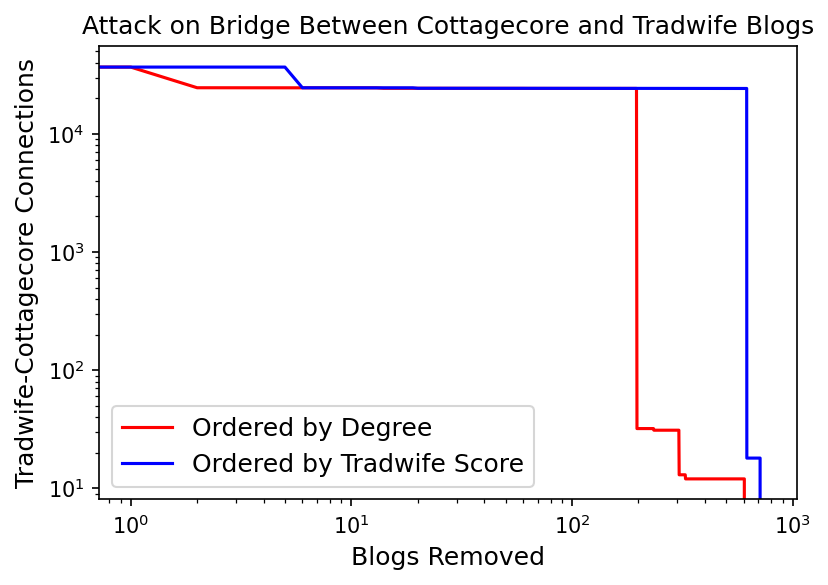

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=150)

ax.loglog(x_deg, y_deg,'r-', label = "Ordered by Degree")
ax.loglog(x_tradwife, y_tradwife, 'b-', label="Ordered by Tradwife Score")

ax.set_xlabel("Blogs Removed", fontsize=12)
ax.set_ylabel("Tradwife-Cottagecore Connections", fontsize=12)
ax.legend(fontsize=12)
ax.set_title("Attack on Bridge Between Cottagecore and Tradwife Blogs")

plt.show()

Link Prediction

In [16]:
# lp_l3 <- function(g){
#   non_edges <- get_non_edges(g)
#   m <- as_adjacency_matrix(g, names = FALSE)
#   # Degree-normalise the adjacency matrix
#   D <- Matrix(diag(1/sqrt(degree(g))))
#   m <- (D %*% m) %*% D
#   # Compute the L3 score
#   l3 <- (m %*% m) %*% m
#   prediction <- tibble(nodeA = non_edges[, 1], nodeB = non_edges[, 2],
#                        scr = l3[non_edges]) %>%
#     arrange(desc(scr))
#   return(prediction)
# }

def lp_l3(G, threshold):
    nodelist = list(dict(G.degree()).keys())
    m = nx.to_scipy_sparse_array(G, nodelist=nodelist, format = 'csr') #ordering node by degree dict for normalization
    #degree normalize adjacency matrix
    D = scipy.sparse.diags([1/math.sqrt(val) for val in list(dict(G.degree()).values())], 0, format="csr")
    m = (D@m)@D
    l3 = (m@m)@m
    print("finding indexes above threshold")
    p = l3 > threshold
    row, col, value = scipy.sparse.find(p)
    print("packing up values")
    edgedict = {(nodelist[i], nodelist[j]):l3[i,j] for i, j in zip(row, col)}
    return edgedict




In [55]:
dates = pd.date_range('2019-01-01','2022-08-01', freq='MS').strftime("%Y-%m-%d %H:%M:%S").tolist()

In [ ]:
start = 0
mid = 2
end = 5
prediction_dict = {"start time":[], "mid time":[], "end time":[], "possible_edges":[], "correctly_predicted_edges":[]}
threshold = 0.2
while end<36:
    print(start)
    df1 = df[(df['time_posted'] > dates[start]) & (df['time_posted'] < dates[mid])]
    G1 = make_bipartite(df1)
    df2 = df[(df['time_posted'] > dates[mid]) & (df['time_posted'] < dates[end])]
    G2 = make_bipartite(df2)
    predicted_edges = lp_l3(G1, threshold)
    true_edges = set(G2.edges()).difference(set(G1.edges()))
    predicted_edges_set = set(predicted_edges.keys())
    correctly_predicted_edges = true_edges.intersection(predicted_edges_set)
    prediction_dict["start time"].append(dates[start])
    prediction_dict["mid time"].append(dates[mid])
    prediction_dict['end time'].append(dates[end])
    prediction_dict["possible_edges"].append(len(true_edges))
    prediction_dict["correctly_predicted_edges"].append(len(correctly_predicted_edges))
    start = start + 1
    mid = mid + 1
    end = end + 1



In [61]:
print(prediction_dict)

{'start time': ['2019-01-01 00:00:00', '2019-02-01 00:00:00', '2019-03-01 00:00:00', '2019-04-01 00:00:00', '2019-05-01 00:00:00', '2019-06-01 00:00:00', '2019-07-01 00:00:00', '2019-08-01 00:00:00', '2019-09-01 00:00:00', '2019-10-01 00:00:00', '2019-11-01 00:00:00', '2019-12-01 00:00:00', '2020-01-01 00:00:00', '2020-02-01 00:00:00', '2020-03-01 00:00:00', '2020-04-01 00:00:00', '2020-05-01 00:00:00', '2020-06-01 00:00:00', '2020-07-01 00:00:00', '2020-08-01 00:00:00', '2020-09-01 00:00:00', '2020-10-01 00:00:00', '2020-11-01 00:00:00', '2020-12-01 00:00:00', '2021-01-01 00:00:00', '2021-02-01 00:00:00', '2021-03-01 00:00:00', '2021-04-01 00:00:00', '2021-05-01 00:00:00', '2021-06-01 00:00:00', '2021-07-01 00:00:00'], 'mid time': ['2019-03-01 00:00:00', '2019-04-01 00:00:00', '2019-05-01 00:00:00', '2019-06-01 00:00:00', '2019-07-01 00:00:00', '2019-08-01 00:00:00', '2019-09-01 00:00:00', '2019-10-01 00:00:00', '2019-11-01 00:00:00', '2019-12-01 00:00:00', '2020-01-01 00:00:00', '202

In [72]:
print("saving to pickle file...")
prediction_df = pd.DataFrame.from_dict(prediction_dict)
prediction_df.to_pickle("link_prediction.pkl", compression='infer', protocol=5, storage_options=None)

saving to pickle file...


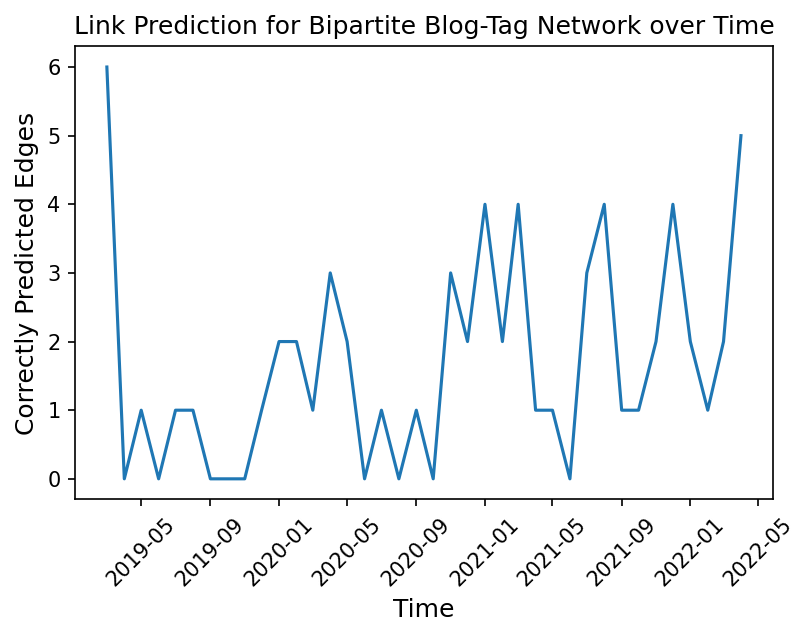

In [80]:
fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=150)

prediction_df["mid time"] = prediction_df["mid time"].astype('datetime64[ns]')

ax.plot(prediction_df["mid time"], prediction_df["correctly_predicted_edges"])


ax.set_xlabel("Time", fontsize=12)
ax.set_ylabel("Correctly Predicted Edges", fontsize=12)
plt.xticks(rotation = 45)
ax.set_title("Link Prediction for Bipartite Blog-Tag Network over Time")

plt.show()

In [311]:
#checking overlap between tags over time
def get_overlap_score(tags):
    tradtags = set(["tradfem","tradwife","tradblr"])
    cottagecoretags = set(["cottagecore", "Cottagecore"])
    #use sets and booelan logic to check overlap, create column, group by month
    if len(tradtags.intersection(set(tags))) > 0 and len(cottagecoretags.intersection(set(tags))) > 0:
        return 1
    else:
        return 0
df['overlap'] = df.apply(lambda row: get_overlap_score(row['tags']), axis=1)
overlapdf = df.groupby([df.time_posted.dt.to_period('M')]).sum('tradwife_score').reset_index()[["time_posted", "overlap"]]


c:\Users\melka\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


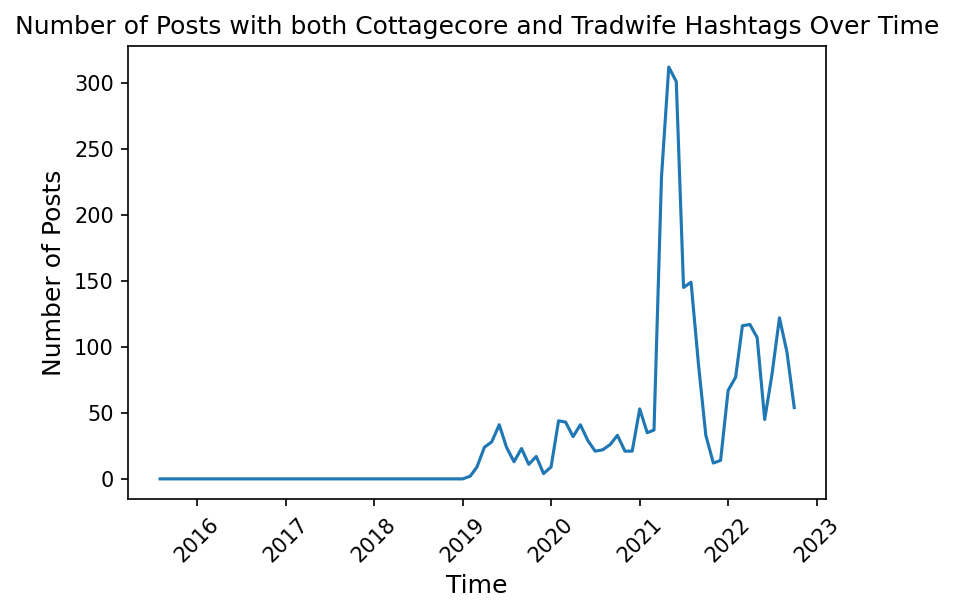

In [312]:
fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=150)

overlapdf["time_posted"] = overlapdf["time_posted"].astype('datetime64[ns]')

ax.plot(overlapdf["time_posted"], overlapdf["overlap"])


ax.set_xlabel("Time", fontsize=12)
ax.set_ylabel("Number of Posts", fontsize=12)
plt.xticks(rotation = 45)
ax.set_title("Number of Posts with both Cottagecore and Tradwife Hashtags Over Time")

plt.show()

Check for converts from pure cottagecore to posting tradwife content

In [8]:
df['time_posted'] = pd.to_datetime(df.time_posted)

In [9]:
dates = pd.date_range('2018-01-01','2022-08-01', freq='MS').strftime("%Y-%m-%d %H:%M:%S").tolist()

In [13]:
converts = set()
non_converts = set()
for date in dates:
    df["post_count"]=1
    df1 = df[(df['time_posted'] > '2016-01-01 00:00:00') & (df['time_posted'] < date)] #first half
    df1 = df1.groupby([df1.blog_name]).sum('tradwife_score').reset_index()
    df1 = df1[df1["post_count"]>3]
    df2 = df[(df['time_posted'] > date) & (df['time_posted'] < '2022-09-01 00:00:00')] #second half
    df2 = df2.groupby([df2.blog_name]).sum('tradwife_score').reset_index()
    #df2 = df2[df2["post_count"]>10]
    #want those who had no tradwife score in first half and nonnegative tradwife score in second half
    cottagecore1 = set(df1[df1['tradwife_score']==0]['blog_name'])
    tradwife2 = set(df2[df2['tradwife_score']>0]['blog_name'])
    converts = converts.union(cottagecore1.intersection(tradwife2))
    

In [14]:
print(converts)

{'fairmaidnelly', 'mossyredwood', 'sugar-seeds', 'touchofhoneyy', 'perfectmoneygoopdiplomat', 'princessroseopalite', 'no-thoughts-just-cryptid', 'ashesofgo1d', 'l1lithh', 'femmecottage', 'jadoremonhoney', 'ladyofatraditionalkind', 'stickandpokesdontfade', 'cosimacore', 'walkingscandalrambleramble', 'peanutbutterandhunny', 'carrotcakesweetie', 'ladyhomesteader', 'melisssg99', 'sensualdoe', 'aggressivelyfeminine', 'oat-milk-maid', 'an-angels-haven'}


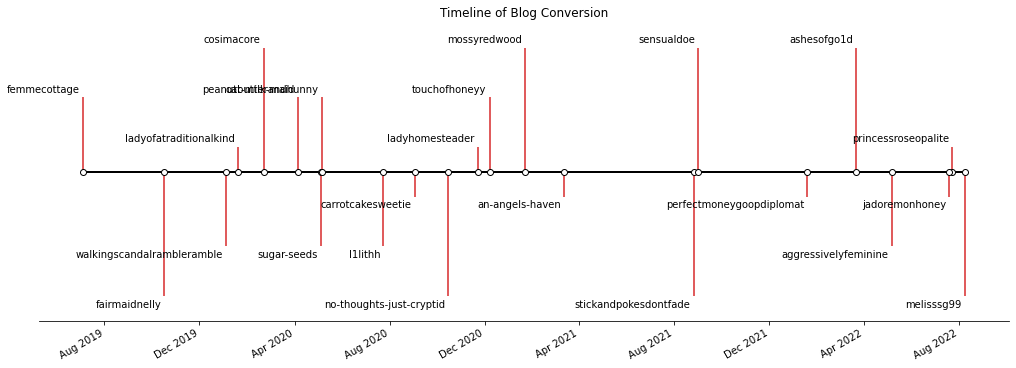

In [63]:
#graph converts tradwife score and posts over time 
df["time_posted"] = pd.to_datetime(df["time_posted"])
#going to plot post count and change color when it becomes a tradwife blog
import matplotlib.dates as mdates

dates = []
for blog in converts:
    converts_df = df.loc[df['blog_name'] == blog].sort_values("time_posted")
    for index, row in converts_df.iterrows():
        if row["tradwife_score"]>0:
            dates.append(row["time_posted"])
            break


# Choose some nice levels
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(14, 5), constrained_layout=True)
ax.set(title="Timeline of Blog Conversion")

ax.vlines(dates, 0, levels, color="tab:red")  # The vertical stems.
ax.plot(dates, np.zeros_like(dates), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.

# annotate lines
for d, l, r in zip(dates, levels, converts):
    ax.annotate(r, xy=(d, l),
                xytext=(-3, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="right",
                verticalalignment="bottom" if l > 0 else "top")

# format xaxis with 4 month intervals
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.1)
plt.show()


In [227]:
#add node attribute for converts to visualize
for node in converts:
    T.nodes[node]["convert"]=True
#saving for visualization
nx.write_graphml(T, "bridge.graphml")

In [210]:
#compare these people's use of bridge tags to other users
bridge_tags = [tag[1:] for tag in tag_score_df.sort_values("score", ascending=False).head(20)["tag"]]
def get_bridge_score(tags, bridge):
    return len(set(tags).intersection(set(bridge)))
df['bridge_score']=df.apply(lambda row: get_bridge_score(row['tags'], bridge_tags), axis=1)

In [211]:
df['num_tags'] = df.apply(lambda row: len(row['tags']), axis=1) #getting number of tags to check

In [236]:
#average bridge score for these converts
converts_df = df.loc[df['blog_name'].isin(converts)]
average_bridge_tags_converts = np.mean(converts_df.groupby(converts_df.blog_name).sum('bridge_score')['bridge_score'])
abtv_stder = np.std(converts_df.groupby(converts_df.blog_name).sum('bridge_score')['bridge_score'])

print("Average Bridge Tags Posted by Convert Blogs: ", average_bridge_tags_converts)
#converts_df.groupby(converts_df.blog_name).sum('bridge_score').bridge_score.hist(bins=20)
#plt.yscale("log")
#plt.show()

#average bridge score for those that never posted tradwife
non_converts_df = df[df["tradwife_score"]==0]
average_bridge_tags_non_converts = np.mean(non_converts_df.groupby(non_converts_df.blog_name).sum('bridge_score')['bridge_score'])
abtnc_stder = np.std(non_converts_df.groupby(non_converts_df.blog_name).sum('bridge_score')['bridge_score'])
print("Average Bridge Tags Posted by Cottagecore Blogs: ", average_bridge_tags_non_converts)
#non_converts_df.groupby(non_converts_df.blog_name).sum('bridge_score').bridge_score.hist(bins=20)
#plt.yscale("log")
#plt.show()

#is this just because these people post a lot?

#average tags posted for these converts
converts_df = df.loc[df['blog_name'].isin(converts)]
average_tag_converts = np.mean(converts_df.groupby(converts_df.blog_name).sum('bridge_score')['num_tags'])
atc_stder = np.std(converts_df.groupby(converts_df.blog_name).sum('bridge_score')['num_tags'])
print("Average Tags Posted by Convert Blogs: ", average_tag_converts)

#average tags posted for those that never posted tradwife
non_converts_df = df[df["tradwife_score"]==0]
average_tag_non_converts = np.mean(non_converts_df.groupby(non_converts_df.blog_name).sum('bridge_score')['num_tags'])
atnc_stder = np.std(non_converts_df.groupby(non_converts_df.blog_name).sum('bridge_score')['num_tags'])
print("Average Tags Posted by Cottagecore Blogs: ", average_tag_non_converts)



Average Bridge Tags Posted by Convert Blogs:  114.95652173913044
Average Bridge Tags Posted by Cottagecore Blogs:  6.532341217114005
Average Tags Posted by Convert Blogs:  787.6086956521739
Average Tags Posted by Cottagecore Blogs:  44.17520595269732


In [263]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [247]:
regression = df.groupby(df.blog_name, as_index=False).sum('bridge_score')
regression['convert'] = 0
regression.loc[regression['blog_name'].isin(converts), 'convert'] = 1

In [292]:
x = np.asarray(regression['bridge_score']).reshape(-1, 1)
#x = np.asarray(regression["num_tags"]).reshape(-1,1)
y = np.asarray(regression["convert"])

In [305]:
#definining weights to help with unbalanced classes
W = {0:1, 1:5000}
i = 0
aucs = []
while i<20:
    X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                        stratify=y, 
                                                        test_size=0.2)
    model = LogisticRegression(solver='liblinear', random_state=0, class_weight=W).fit(X_train, y_train)
    aucs.append(roc_auc_score(y_test, model.predict(X_test)))
    i = i + 1
print(np.mean(aucs))

0.9190888278388277


In [231]:
all_converts = converts

In [233]:
print(dates)

['2018-01-01 00:00:00', '2018-02-01 00:00:00', '2018-03-01 00:00:00', '2018-04-01 00:00:00', '2018-05-01 00:00:00', '2018-06-01 00:00:00', '2018-07-01 00:00:00', '2018-08-01 00:00:00', '2018-09-01 00:00:00', '2018-10-01 00:00:00', '2018-11-01 00:00:00', '2018-12-01 00:00:00', '2019-01-01 00:00:00', '2019-02-01 00:00:00', '2019-03-01 00:00:00', '2019-04-01 00:00:00', '2019-05-01 00:00:00', '2019-06-01 00:00:00', '2019-07-01 00:00:00', '2019-08-01 00:00:00', '2019-09-01 00:00:00', '2019-10-01 00:00:00', '2019-11-01 00:00:00', '2019-12-01 00:00:00', '2020-01-01 00:00:00', '2020-02-01 00:00:00', '2020-03-01 00:00:00', '2020-04-01 00:00:00', '2020-05-01 00:00:00', '2020-06-01 00:00:00', '2020-07-01 00:00:00', '2020-08-01 00:00:00', '2020-09-01 00:00:00', '2020-10-01 00:00:00', '2020-11-01 00:00:00', '2020-12-01 00:00:00', '2021-01-01 00:00:00', '2021-02-01 00:00:00', '2021-03-01 00:00:00', '2021-04-01 00:00:00', '2021-05-01 00:00:00', '2021-06-01 00:00:00', '2021-07-01 00:00:00', '2021-08-0

In [234]:
#creating convert visualizations
converts = set()
i = 0
for date in dates:
    df["post_count"]=1
    df1 = df[(df['time_posted'] > '2016-01-01 00:00:00') & (df['time_posted'] < date)] #first half
    df1 = df1.groupby([df1.blog_name]).sum('tradwife_score').reset_index()
    df1 = df1[df1["post_count"]>3]
    df2 = df[(df['time_posted'] > date) & (df['time_posted'] < '2022-09-01 00:00:00')] #second half
    df2 = df2.groupby([df2.blog_name]).sum('tradwife_score').reset_index()
    #df2 = df2[df2["post_count"]>10]
    #want those who had no tradwife score in first half and nonnegative tradwife score in second half
    cottagecore1 = set(df1[df1['tradwife_score']==0]['blog_name'])
    tradwife2 = set(df2[df2['tradwife_score']>0]['blog_name'])
    prev_size = len(converts)
    converts = converts.union(cottagecore1.intersection(tradwife2))
    if date in ['2019-01-01 00:00:00', '2020-01-01 00:00:00', '2021-01-01 00:00:00', '2022-01-01 00:00:00']:
        #create graph from df up to that point
        print("creating graph")
        data = df[(df['time_posted'] > '2016-01-01 00:00:00') & (df['time_posted'] < date)]
        N = make_bipartite(data)
        N = build_bridge(N)
        for node in all_converts:
            if node in N.nodes():
                N.nodes[node]["convert"] = True
        print("saving graph")
        nx.write_graphml(N, "bridge"+str(i)+".graphml")
        i = i + 1
        



creating graph


C:\Users\melka\AppData\Local\Temp\ipykernel_14644\2953207649.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tradwife_score']=df.apply(lambda row: get_tradwife_score(row['tags']), axis=1)


Is bipartite? True
Num nodes: 7812
Num edges: 18791
saving graph
creating graph


C:\Users\melka\AppData\Local\Temp\ipykernel_14644\2953207649.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tradwife_score']=df.apply(lambda row: get_tradwife_score(row['tags']), axis=1)


Is bipartite? True
Num nodes: 36209
Num edges: 115889
saving graph
creating graph


C:\Users\melka\AppData\Local\Temp\ipykernel_14644\2953207649.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tradwife_score']=df.apply(lambda row: get_tradwife_score(row['tags']), axis=1)


Is bipartite? True
Num nodes: 103861
Num edges: 382715
saving graph
creating graph


C:\Users\melka\AppData\Local\Temp\ipykernel_14644\2953207649.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tradwife_score']=df.apply(lambda row: get_tradwife_score(row['tags']), axis=1)


Is bipartite? True
Num nodes: 150968
Num edges: 568308
saving graph


Latent Influence Network

In [81]:
#getting data into cascades format to put into R
#want a column of blogs and then a column of each tag with the date in the cell corresponding to the time the tag was used
#want to do this for each time a tag is used, may repeat blogs
def get_tag_score(tags, tag):
    return tags.count(tag)
cascades_list = []
for tag in ["tradfem","tradwife","tradblr","traditional", "trad", "traditional femininity", "sahm", "stay at home mom", "modesty", "Tradwife", "traditional gender roles", "Tradfem", "feminism", "feminine"]:
    tagdf = df[(df['time_posted'] > '2021-01-01 00:00:00') & (df['time_posted'] < '2022-01-01 00:00:00')]
    tagdf['tag_score']=tagdf.apply(lambda row: get_tag_score(row['tags'], tag), axis=1)
    tagdf = tagdf[tagdf['tag_score']>0]
    tagdf['cascade_id'] = tag
    tagdf = tagdf[["blog_name", "time_posted", "cascade_id"]]
    cascades_list.append(tagdf)

cascades = pd.concat(cascades_list, 0, ignore_index=True)


C:\Users\melka\AppData\Local\Temp\ipykernel_16688\1555179413.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tagdf['tag_score']=tagdf.apply(lambda row: get_tag_score(row['tags'], tag), axis=1)
C:\Users\melka\AppData\Local\Temp\ipykernel_16688\1555179413.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tagdf['cascade_id'] = tag
C:\Users\melka\AppData\Local\Temp\ipykernel_16688\1555179413.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [82]:
cascades.to_csv("cascades.csv")